In [918]:
import pandas as pd
import numpy as np
import math as m

Importing the data. We see that we have to classify 10 images. Hence it is a multiclass classification problem

In [919]:
data = pd.read_csv('fashion-mnist_train.csv')
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Converting the dataframe into a numpy array and getting the number of rows and columns for the matrix

In [920]:
data = np.array(data)
m,n = data.shape
np.random.shuffle(data)

Dividing data into development and training data. Dividing data into input and labels too

In [921]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev/255

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train/255
a,b = X_train.shape
X_train1 = X_train.T

In [922]:
import random
import matplotlib.pyplot as plt

Displaying some of the examples in our data set as images

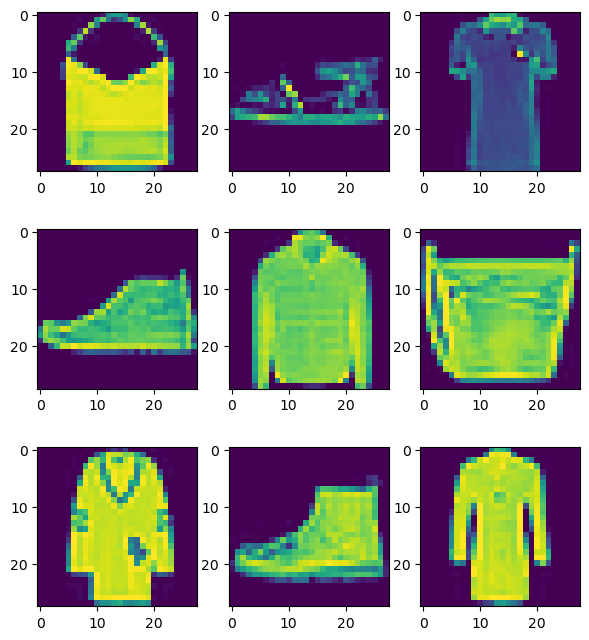

In [923]:
fig = plt.figure(figsize = (7,8))
for j in range(0,9):
    fig.add_subplot(3,3,j+1)
    idx = random.randint(0,len(X_train1))
    pixels = X_train1[idx]
    pixels = pixels.reshape(28,28)
    plt.imshow(pixels)

We are creating a neural network with one input layer of 784 neurons , one hidden layer of 10 neurons and the output layer has 10 neurons.

Creating a function that initialises the parameters w1,b1,w2,b2

In [924]:
def init_params():
    
    w1 = np.random.uniform(-0.4,0.4,size = (10,784))
    b1 = np.random.uniform(-0.4,0.4, size = (10,1))
    w2 = np.random.uniform(-0.4,0.4,size = (10,10))
    b2 = np.random.uniform(-0.4,0.4, size = (10,1))
    return w1,b1,w2,b2

In [925]:
w1,b1,w2,b2 = init_params()

Definng the activatin functions ReLU and Softmax. I used ReLU and Softmax as ReLU is the most generally used activation function for hidden layers, and softmax is best used for multiclassification problems like this one

In [926]:
def ReLU(Z):
    return np.maximum(0,Z)

In [927]:
def softmax(Z):
    e = np.exp(Z)
    return e/np.sum(e,axis = 0)

Defining the forward propagation function. Z1 is the output of input layer, Z2 is the output of the hidden layer and A2 is the expected output

In [928]:
def forward_prop(w1,b1,w2,b2,X):
    Z1 = w1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = w2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1,A1,Z2,A2

In [929]:
Z1,A1,Z2,A2 = forward_prop(w1,b1,w2,b2,X_dev)

We defined a onehotencoder function as the labels are numbers ranging from 0-9. We need to convert each number into an array of zeros and ones to match the actual output

In [930]:
def onehotencoder(Y):
    one_hot_Y = np.zeros((Y.size,Y.max() + 1))
    one_hot_Y[np.arange(Y.size),Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [931]:
def deriv_ReLU(Z):
    return Z >0

For the backpropagation function, the Loss function is defined as (y_predicted - y-train) for simple differentiation
L2 regularisation is used as the model is simple enough and the aim is to reduce the value of weights to solve the problem of vanishing gradients

In [932]:
def backprop(Z1,A1,Z2,A2,X,Y,w2,reg_par):
    m = Y.size
    one_hot_Y = onehotencoder(Y)
    
    l2_reg_exp = (1/(2*m))*reg_par*(np.sum(np.square(w2)) + np.sum(np.square(w1)))
    
    dZ2 = (A2 - one_hot_Y) + l2_reg_exp
    mse_loss = np.sum((A2-one_hot_Y)**2) + l2_reg_exp
    cce_loss = np.sum(one_hot_Y*np.log(A2))
    
    dw2 = 1/m*(dZ2.dot(A1.T)) + 1/m*reg_par*np.sum(w2)
    
    db2 = 1/m*(np.sum(dZ2)) 
    
    dZ1 = w2.T.dot(dZ2)*deriv_ReLU(Z1) 
    
    dw1 = 1/m*(dZ2.dot(X.T))+ 1/m*reg_par*np.sum(w1)
    
    db1 = 1/m*(np.sum(dZ1))
    
    return dw1,dw2,db1,db2,mse_loss,cce_loss,one_hot_Y

In [933]:
dw1,dw2,db1,db2,mse_loss,cce_loss,one_hot_Y = backprop(Z1,A1,Z2,A2,X_dev,Y_dev,w2,0.1)
cce_loss

-3090.041720266153

Updating the parameters with the derivatives and alpha

In [934]:
def update_params(w1,b1,w2,b2,dw1,db1,dw2,db2,alpha):
    w1 = w1 - alpha*dw1
    b1 = b1 - alpha*db1
    w2 = w2 - alpha*dw2
    b2 = b2 - alpha*db2
    alpha = alpha/1.01
    return w1,b1,w2,b2

In [935]:
w1,b1,w2,b2 = update_params(w1,b1,w2,b2,dw1,db1,dw2,db2,0.1)
w1

array([[-0.33700296,  0.24414811, -0.19471012, ..., -0.32283397,
         0.13693994,  0.33108481],
       [-0.36913023, -0.10745314,  0.36580207, ...,  0.30026191,
        -0.31825388, -0.2724464 ],
       [-0.06628911, -0.1856772 ,  0.09707147, ..., -0.23735111,
         0.36580259, -0.13810174],
       ...,
       [-0.06404951, -0.19074624,  0.32434439, ..., -0.24243746,
         0.31754137,  0.05073369],
       [ 0.0157685 , -0.02938826,  0.21218663, ..., -0.03954341,
        -0.05798513,  0.33018301],
       [ 0.00811056,  0.33731094, -0.28560815, ..., -0.33684596,
        -0.2575962 , -0.07338377]])

In [936]:
def get_predictions(A2):
    return np.argmax(A2,0)

In [937]:
def get_accuracy(predictions, Y):
    
    return np.sum(predictions == Y)/Y.size

In [938]:
X = np.array([[0,0,1,0,1],[0,0,1,0,1]])
Y = np.array([[1,1,1,0,1],[0,0,0,1,0]])
precision = precisionfor1(X,Y)
precision

0.4

In [939]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn import metrics

In [940]:
def gradient_descent(X,Y,iterations,alpha):
    w1,b1,w2,b2 = init_params()
    reg_par = 0.01
    for i in range(iterations):
        Z1,A1,Z2,A2 = forward_prop(w1,b1,w2,b2,X)
        dw1,dw2,db1,db2,mse_loss,cce_loss,one_hot_Y = backprop(Z1,A1,Z2,A2,X,Y,w2,reg_par)
        w1,b1,w2,b2 = update_params(w1,b1,w2,b2,dw1,db1,dw2,db2,alpha)
        arg_A2 = get_predictions(A2)
        #y_predicted = onehotencoder(arg_A2)
        #precision = precisionfor1(y_predicted,one_hot_Y)
        # printing the accuracy and loss of model after every 100 iterations
        if i%50 == 0 :
            print('Iteration', i)
            print('Accuracy',get_accuracy(arg_A2, Y))
            print('The MSE loss is:',mse_loss)
            print('The CCE loss is : ',cce_loss)
            print('The precision score is:',precision_score(Y,arg_A2,zero_division = 0,average = 'macro'))
            print('The recall score is: ',recall_score(Y,arg_A2,average = 'macro'))
            print('The f1 score is: ', f1_score(Y,arg_A2,average = 'macro'))
            #print('the precision score is:',precision_score(Y,arg_A2,average = 'macro'))
            print(set(Y) - set(arg_A2))
    return w1,b1,w2,b2,arg_A2

In [942]:
w1,b1,w2,b2,y_predicted_train = gradient_descent(X_train,Y_train,400,0.09)

Iteration 0
Accuracy 0.06832203389830509
The MSE loss is: 60924.05246792188
The CCE loss is :  -175391.76943935597
The precision score is: 0.08815188966584821
The recall score is:  0.06831281780989734
The f1 score is:  0.04274705839920664
{7}
Iteration 50
Accuracy 0.6213389830508474
The MSE loss is: 29401.536291775534
The CCE loss is :  -61571.87122749661
The precision score is: 0.607766229069197
The recall score is:  0.6212604927797155
The f1 score is:  0.5945285100889386
set()
Iteration 100
Accuracy 0.6824576271186441
The MSE loss is: 24870.195841420664
The CCE loss is :  -50454.53104010671
The precision score is: 0.6767635486977432
The recall score is:  0.6823671225344563
The f1 score is:  0.6650041088287344
set()
Iteration 150
Accuracy 0.7131186440677966
The MSE loss is: 22750.461935598156
The CCE loss is :  -45543.5083905
The precision score is: 0.7081061494395071
The recall score is:  0.7130169338021213
The f1 score is:  0.7008778353792577
set()
Iteration 200
Accuracy 0.731355932

From what we can observe, the model works fine on using the training data.
However, too many iterations are needed to increase the accuracy of the model, so optimisation is recquired.
The model does not get stuck at one local minima on running it multiple times

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (2).

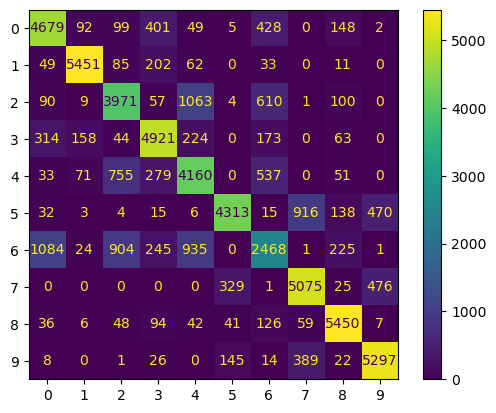

In [943]:
confusion_matrix = metrics.confusion_matrix(Y_train, y_predicted_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [944]:
w1,b1,w2,b2,y_predicted_dev = gradient_descent(X_dev,Y_dev,70,0.1)

Iteration 0
Accuracy 0.093
The MSE loss is: 1148.2487328543327
The CCE loss is :  -3290.4667839341573
The precision score is: 0.14477914572254197
The recall score is:  0.08541553061888214
The f1 score is:  0.03845110771245787
{0, 3, 4}
Iteration 50
Accuracy 0.598
The MSE loss is: 515.0872977833574
The CCE loss is :  -1067.6043764502335
The precision score is: 0.610229426298405
The recall score is:  0.5936209195048525
The f1 score is:  0.5431074216569545
set()


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (2).

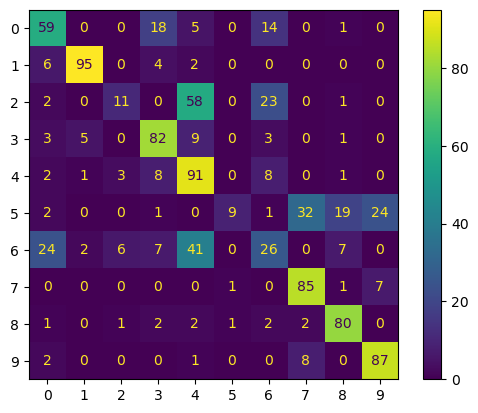

In [945]:
confusion_matrix = metrics.confusion_matrix(Y_dev, y_predicted_dev)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [946]:
test_data = pd.read_csv('fashion-mnist_test.csv')

In [947]:
test_data = np.array(test_data)
k,l = test_data.shape
np.random.shuffle(test_data)

In [948]:
test_data = test_data.T
Y_test = test_data[0]
X_test = test_data[1:n]
X_test = X_test/255

In [949]:
w1,b1,w2,b2,y_predicted_test = gradient_descent(X_test,Y_test,700,0.08)

Iteration 0
Accuracy 0.0541
The MSE loss is: 10980.52736920399
The CCE loss is :  -35405.7199459472
The precision score is: 0.08436171737654505
The recall score is:  0.0541
The f1 score is:  0.024450680383747942
{6}
Iteration 50
Accuracy 0.6135
The MSE loss is: 5159.029517317074
The CCE loss is :  -10828.157931461332
The precision score is: 0.6099780435888086
The recall score is:  0.6135
The f1 score is:  0.5916612257717546
set()
Iteration 100
Accuracy 0.6898
The MSE loss is: 4180.920000895169
The CCE loss is :  -8497.613657949923
The precision score is: 0.6853111508045567
The recall score is:  0.6898000000000001
The f1 score is:  0.679212124663024
set()
Iteration 150
Accuracy 0.7289
The MSE loss is: 3725.2602132551533
The CCE loss is :  -7529.187271675515
The precision score is: 0.7253583688775681
The recall score is:  0.7289000000000001
The f1 score is:  0.7214096681600225
set()
Iteration 200
Accuracy 0.7484
The MSE loss is: 3484.3314991189663
The CCE loss is :  -7016.070619020549
Th